In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
import shap
import time

In [44]:
# Last inn data
data = pd.read_csv('Data/data_grouped.csv')
# lag nye navn fra-sone-6 og til-sone-6 til fra-sone og til-sone
data = data.rename(columns={'fra-sone-6': 'fra-sone', 'til-sone-6': 'til-sone', 'fri_hen_priv': 'fritid'})
# Lag en hjelpe-tabell med unike soner og befolkning
pop_lookup = data[['fra-sone', 'befolkning']].drop_duplicates()
pop_lookup.columns = ['sone', 'til_befolkning']

# Slå opp befolkning for to_zone basert på from_zone-informasjon
df = data.merge(pop_lookup, left_on='til-sone', right_on='sone', how='left')
df = df.drop(columns='sone')

data = df


# Random Forrest

I den neste delen modellers en random forrest modell mer man også finner Hyper parameters

In [45]:
# Kopier datasettet for å sikre at vi ikke endrer originalen
rf_data = data.copy()

# Konverter `fra-sone`, `til-sone` og `tid` til numeriske verdier med LabelEncoder
label_encoder_fra = LabelEncoder()
rf_data['fra-sone-encoded'] = label_encoder_fra.fit_transform(rf_data['fra-sone'])

label_encoder_til = LabelEncoder()
rf_data['til-sone-encoded'] = label_encoder_til.fit_transform(rf_data['til-sone'])

label_encoder_tid = LabelEncoder()
rf_data['tid-encoded'] = label_encoder_tid.fit_transform(rf_data['tid'])


X_1 = rf_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']]
# Definer input- og output-variabler
X = X_1.values

y = rf_data['reiser'].values  # Ingen log-transformasjon!
pt_y = PowerTransformer()
y_trans = pt_y.fit_transform(y.reshape(-1, 1)).ravel()  # PowerTransformer
y_log = np.log1p(y)  # Log-transformasjon av y for å håndtere skjevfordeling

# Split data i trening og testsett
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # bruk y_log og y_trans ved ønske

# Sett sammen et fullstendig treningssett med X_test og y_test:
feature_names = X_1.columns.tolist()
# Lag DataFrame for X_test
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_test_df = pd.DataFrame(y_test, columns=['reiser']) 
# Sett sammen X_test og y_test
t_set = pd.concat([X_test_df.reset_index(drop=True), y_test_df.reset_index(drop=True)], axis=1)


### Fordeling av tranformerte y-verdier

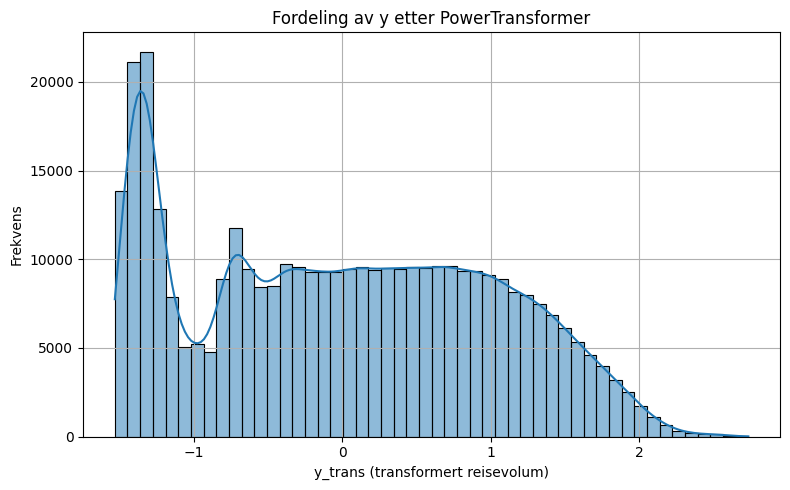

In [46]:
plt.figure(figsize=(8, 5))
sns.histplot(y_trans, bins=50, kde=True)
plt.title("Fordeling av y etter PowerTransformer")
plt.xlabel("y_trans (transformert reisevolum)")
plt.ylabel("Frekvens")
plt.grid(True)
plt.tight_layout()
plt.show()


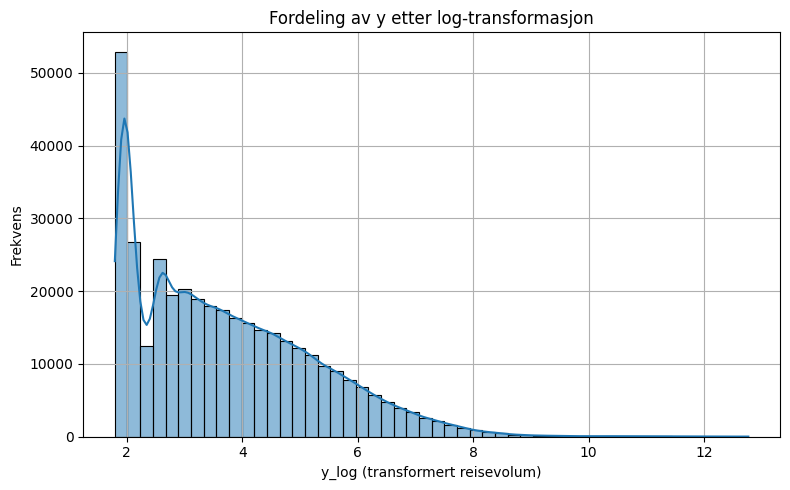

In [47]:
plt.figure(figsize=(8, 5))
sns.histplot(y_log, bins=50, kde=True)
plt.title("Fordeling av y etter log-transformasjon")
plt.xlabel("y_log (transformert reisevolum)")
plt.ylabel("Frekvens")
plt.grid(True)
plt.tight_layout()
plt.show()


### Hyperparametere

In [345]:
param_dist = {
    'n_estimators': randint(50, 500), 
    'max_depth': [30, 40, 60, 100],  
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}


In [346]:
# Initialiser Randomized Search
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,  # Test kun 20 tilfeldige kombinasjoner (reduserer tid)
    cv=3,  # Kjør 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

In [ ]:
best_params = random_search.best_params_
print(f"Beste hyperparametere: {best_params}")

In [335]:
best_params = {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 156} #vanlig

In [104]:
best_params = {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 150} # PT

In [25]:
best_params = {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 451} # log

### Modellering

In [ ]:

start = time.time()

rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

end = time.time()
print(f"Treningstid: {end - start:.2f} sekunder")
start2 = time.time()

y_pred = rf_best.predict(X_test)
end2 = time.time()
print(f"Prediksjonstid: {end2 - start2:.2f} sekunder")
print(y_pred.shape)
print(y_test.shape)

# Ved transformasjon
#y_pred = np.expm1(y_pred)
#y_test = np.expm1(y_test)
#y_pred = pt_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
#y_test = pt_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

### Resultater

In [ ]:
print("\nModellens ytelse med optimaliserte hyperparametere:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

In [ ]:
# Finn MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

### Plott fatiske verdier mot predikerte verdier

In [ ]:
# Plot faktisk mot predikert
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label='Perfect Prediction')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('True vs Predicted Values - RF')
plt.legend()
plt.grid(True)
mask = y_test <= 10000
filtered_y_test = y_test[mask]
filtered_y_pred = y_pred[mask]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_test, filtered_y_pred, alpha=0.5, label='Predicted vs True')
plt.plot([min(filtered_y_test), max(filtered_y_test)], [min(filtered_y_test), max(filtered_y_test)], '--r', label='Perfect Prediction')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('True vs Predicted Values (Filtered)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Finne median MAPE
errors = abs(y_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")



### Sjekk overtilpasning

In [ ]:
# sammenlign resultater med prediksjonser på testsettet med prediksjoner på treningssettet
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nModellens ytelse med optimaliserte hyperparametere:")
print(f"Mean Squared Error (MSE) - Treningssett: {mse_train:.2f}")
print(f"Mean Squared Error (MSE) - Testsett: {mse_test:.2f}")
print(f"Mean Absolute Error (MAE) - Treningssett: {mae_train:.2f}")
print(f"Mean Absolute Error (MAE) - Testsett: {mae_test:.2f}")
print(f"R-squared (R2) - Treningssett: {r2_train:.2f}")
print(f"R-squared (R2) - Testsett: {r2_test:.2f}")


### Kryssvalidasjon

In [ ]:


kf = KFold(n_splits=5, shuffle=True, random_state=42) # Shuffle og tilfeldig utvalg
scores = cross_val_score(rf_best, X, y, cv=kf, scoring='neg_mean_squared_error')


mse_scores = -scores

print(f"RMSE scores: {mse_scores}")
print(f"Mean RMSE: {mse_scores.mean()}")
print(f"Standard deviation: {mse_scores.std()}")

mape_scores = 100 * np.mean(np.abs((y - rf_best.predict(X)) / y))


mae_scores = []
r2_scores = []
mape_scores = []

for train_idx, test_idx in kf.split(X):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    rf_best.fit(X_train_fold, y_train_fold)
    y_pred_fold = rf_best.predict(X_test_fold)
    
    mae_scores.append(mean_absolute_error(y_test_fold, y_pred_fold))
    r2_scores.append(r2_score(y_test_fold, y_pred_fold))
    mape_scores.append(np.mean(np.abs((y_test_fold - y_pred_fold) / y_test_fold)) * 100)


print(f"MAE scores: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Standard deviation MAE: {np.std(mae_scores):.2f}")

print(f"R2 scores: {r2_scores}")
print(f"Mean R2: {np.mean(r2_scores):.2f}")
print(f"Standard deviation R2: {np.std(r2_scores):.2f}")

print(f"MAPE scores: {mape_scores}")
print(f"Mean MAPE: {np.mean(mape_scores):.2f}%")
print(f"Standard deviation MAPE: {np.std(mape_scores):.2f}%")

### Modellusikkerhet

In [ ]:
# Trener 20 modeller, finner usikkerheten

n_models = 20
seeds = np.random.randint(0, 10000, n_models)

all_predictions = []

for seed in seeds:
    rf = RandomForestRegressor(**best_params, random_state=seed, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    all_predictions.append(y_pred)

# Konverter til numpy array: shape = (n_models, n_test_samples)
all_predictions = np.array(all_predictions)

# Beregn gjennomsnitt og standardavvik
mean_pred = all_predictions.mean(axis=0)
std_pred = all_predictions.std(axis=0)
rel_std_pred = std_pred / (mean_pred + 1e-6)  # +1e-6 for å unngå deling på null

# Eksempel: Vis relativ usikkerhet for de 10 første testprøvene
print("Relativ standardavvik:", rel_std_pred[:10])
print("Gjennomsnittlig prediksjon:", mean_pred[:10])


In [ ]:
# HVa er gjennomsnittlig standardavvik?
mean_std = rel_std_pred.mean()
print(f"Gjennomsnittlig standardavvik: {mean_std:.2f}")
meanst = std_pred.mean()
print(f"Gjennomsnittlig standardavvik: {meanst:.2f}")



### Residualer

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel('Antall reiser (Faktiske verdier)')
plt.ylabel('Residual')
plt.axhline(y=0, color='black', linewidth=2)
plt.title('Residualer mot faktiske verdier')
plt.grid(True)
plt.show()

In [ ]:
# Beregn residualer
residuals = y_test - y_pred

# Filtrer der y_test ≤ 40000
mask = y_test <= 40000
y_test_filtered = y_test[mask]
residuals_filtered = residuals[mask]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test_filtered, residuals_filtered, alpha=0.5)
plt.xlabel('Antall reiser (Faktisk verdier)')
plt.ylabel('Residual')
plt.axhline(y=0, color='black', linewidth=2)
plt.title('Residualer mot Faktisk verdi (≤ 40 000)')
plt.grid(True)
plt.show()


### SHAP



In [ ]:
explainer = shap.TreeExplainer(rf_best, approximate = True)

X_sample = X_test[:1000]
shap_values_sample = explainer.shap_values(X_sample)

In [ ]:
import matplotlib.pyplot as plt
# Velger kun de numeriske feature-navnene
numerical_features = ['befolkning', 'to_befolkning','arbeidsplasser', 'handel', 'fri_hen_priv', 'distanse']

# Finner indeksene til de numeriske feature-navnene i den opprinnelige listen
feature_indices = [i for i, name in enumerate(['fra-sone', 'til-sone', 'tid', 'befolkning', 'to_befolkning', 'arbeidsplasser', 'handel', 'fri_hen_priv', 'distanse']) if name in numerical_features]

# Filtrerer SHAP-verdiene for kun de numeriske features
shap_values_filtered = shap_values_sample[:, feature_indices]
X_filtered = X_sample[:, feature_indices]
numerical_features = ['befolkning', 'befolkning i til-sone', 'arbeidsplasser', 'handel', 'fritid', 'distanse']

# Lager summary-plot uten de kategoriske variablene
shap.summary_plot(shap_values_filtered, X_filtered, max_display=10,
                  show=False, feature_names=numerical_features)
plt.xlim(-1000, 1000)
plt.title('SHAP Summary Plot - RF')
plt.show()

### Analyse av tid og rom

In [ ]:
# Test modellen på datapunkter med ulike verdier. Soner med få/stor befolning, lang/kort distance, mange/få totale reiser. Evner modellen å predikere bedre for noen datatyper enn andre?

# test-data med kun reiser med antall reise < 1000
test_data = t_set[t_set['reiser'] < 1000]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")


In [ ]:
# Test-data med kun reiser med antall reiser < 1000 < 10000
test_data = t_set[(t_set['reiser'] < 10000) & (t_set['reiser'] >= 1000)]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")

In [ ]:
# test-data med kun reiser med antall reiser > 10000
test_data = t_set[t_set['reiser'] >= 10000]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning','arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")

In [ ]:
# Test-data med kun punkter der tid = 'UR'
test_data = t_set[t_set['tid-encoded'] == 2]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")



In [ ]:
# Test-data med kun punkter der tid = 'HELG'
test_data = t_set[t_set['tid-encoded'] == 0]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")

In [ ]:
# Test-data med kun punkter der tid = 'RT'
test_data = t_set[t_set['tid-encoded'] == 1]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")

In [ ]:
# test_data der befolkning er under 500
test_data = t_set[t_set['befolkning'] < 500]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")

In [ ]:
#test_data der befokninger er over 500
test_data = t_set[t_set['befolkning'] > 500]
X_test = test_data[['fra-sone-encoded', 'til-sone-encoded', 'tid-encoded', 'befolkning', 'til_befolkning', 'arbeidsplasser', 'handel', 'fritid', 'distanse']].values
y_test = test_data['reiser'].values

y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModellens ytelse på testsettet:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

errors = abs(y_pred - y_test)

mape = 100 * (errors / y_test)

median_mape = np.median(mape)
print(f"Median MAPE: {median_mape:.2f}%")

mean_mape = np.mean(mape)
print(f"Mean MAPE: {mean_mape:.2f}%")